# The Weisfeiler-Lehman Isomorphism Test

The Weisfeiler-Lehman Isomorphism Test, also called WL-Test, is a classical result from the graph theory. It is an heuristic to find out if two graphs are isomorphic. The problem of the graph isomorphism does not have a definitive solution in polinomial time yet, making some people say it may be NP-Complete. The WL-Test offers one alternative that allows us to estimate it.

However, since this is an heuristic, the test is not perfect. Therefore, it fail in some simple cases and because of that new versions of this test were proposed.

In this notebook we will explore a little about the theory of the test and implement it in its classical form and also some newer versions.

In [3]:
import copy
import pprint
import itertools
import hashlib
import networkx as nx

from collections import Counter

In [4]:
def base_WL(G_, k, verbose, n_set, initial_colors_func, find_neighbors_func):    
    if verbose:
        print('-----------------------------------')
        print('Starting the execution for the graph')
    G, n = n_set(G_)
    colors = initial_colors_func(n)

    old_colors = copy.deepcopy(colors)
    
    if verbose:
        print(f'Initial Color hashes: \n {colors} \n')

    for i in range(len(n)):
        for node in n:
            neigh_colors = "".join([colors[i][0] for i in find_neighbors_func(G, n, node)])
            
            colors[node].extend([neigh_colors])
            colors[node].sort()

        # Update with the hash
        if verbose:
            print(f'Colors before hashes at iteration {i}: {colors} \n')
        colors = {i: [hashlib.sha224("".join(colors[i]).encode('utf-8')).hexdigest()] for i in colors}
                
        if verbose:
            print(f'Colors hashes at iteration {i}: \n {colors} \n')
            print(f'Histogram: \n {sorted(Counter([item for sublist in colors.values() for item in sublist]).items())} \n')
        
        if list(Counter([item for sublist in colors.values() for item in sublist]).values()) == list(Counter([item for sublist in old_colors.values() for item in sublist]).values()) and i != 0:
            if verbose:
                print(f'Converged at iteration {i}!')
            break
        
        old_colors = copy.deepcopy(colors)

    canonical_form = sorted(Counter([item for sublist in colors.values() for item in sublist]).items())
    if verbose:
        print(f'Canonical Form Found: \n {canonical_form} \n')

    return canonical_form

In [5]:
def WL(G, k=2, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        return G, list(G.nodes())
    
    def set_initial_colors(n):
        return {i: [hashlib.sha224("1".encode('utf-8')).hexdigest()] for i in n}
    
    def find_neighbors(G, n, node):
        return G.neighbors(node)
    
    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

In [6]:
def kWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        V_k = [comb for comb in itertools.combinations(V, k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    def find_neighbors(G, V_k, node):
        return [n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1]

    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

In [7]:
def fkWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        V_k = [comb for comb in itertools.product(V, repeat=k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    def find_neighbors(G, V_k, node):
        V = list(G.nodes())
        vals = []
        for i in range(k):
            w = []
            nodes_to_add = [u for u in V if u != V_k[V_k.index(node)][i]]
            for u in nodes_to_add:
                aux = list(V_k[V_k.index(node)])
                aux[i] = u
                w.append(tuple(aux))
            vals.extend(w)
        return vals

    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

In [8]:
def compare_graphs(G1, G2, method='WL', k=2, verbose=False):
    methods = {
        'WL': WL,
        'kWL': kWL,
        'fkWL': fkWL
    }

    # If two graphs have different numbers of nodes they cannot be isomorphic
    if len(G1.nodes()) != len(G2.nodes()):
        if verbose:
            print('Non-Isomorphic by different number of nodes!')
        return False
    
    c1 = methods[method](G1, k, verbose)
    c2 = methods[method](G2, k, verbose)

    return c1 == c2

## Testing the Implementation

In [9]:
def load_graph(file):
    G = nx.read_graphml(file)
    G.graph['phrase'] = G.graph.get('phrase', 'No phrase found')
    return G, G.to_undirected()

# Separar grafos del mismo tamaño

In [10]:
import os
import random
import pandas as pd

GRAPH_DIR = "./UD_Spanish-GSD/"  # Set your desired directory path here
graph_files = [f for f in os.listdir(GRAPH_DIR) if f.endswith(".graphml")]

df = {}

for file in graph_files:
    G, G_undirected = load_graph(os.path.join(GRAPH_DIR, file))
    
    df[file] = {"size": G.number_of_nodes(),
                "phrase": G.graph['phrase']}

df = pd.DataFrame.from_dict(df, orient='index')
df


,size,phrase
es_gsd-ud-train_7825.graphml,9,Nasija es una película del año 2006.
es_gsd-ud-train_12948.graphml,19,"Se alimenta de insectos, que busca entre las h..."
es_gsd-ud-train_9745.graphml,24,Aunque los tres distritos de las Azores y el M...
es_gsd-ud-train_3290.graphml,37,"A cambio de su capital y el riesgo, exigía nad..."
es_gsd-ud-train_1588.graphml,50,En el pasado se produjo un hundimiento del ter...
...,...,...
es_gsd-ud-train_7590.graphml,34,"¿Sólo coincidencia, que tuviese que pasar just..."
es_gsd-ud-train_11797.graphml,29,"Aunque el mejor conocido es el de Tenayuca, a ..."
es_gsd-ud-train_8663.graphml,12,Todas las estaciones se encuentran dentro de F...
es_gsd-ud-train_1945.graphml,15,El se le retiraba el cargo de jefe del Estado ...


In [11]:
df.to_csv("sizes_data.csv")

# Test de isomorfismo

<Axes: title={'center': 'Number of Graphs by Size'}, xlabel='size'>

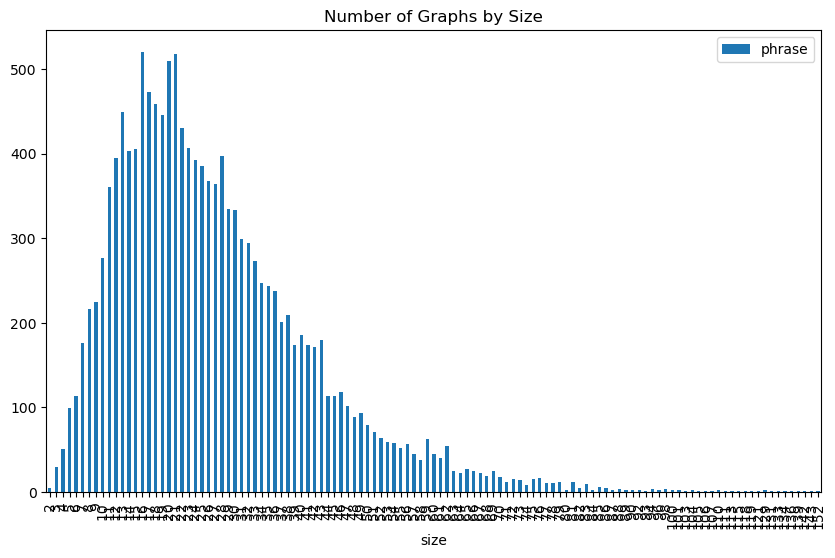

In [12]:
df.groupby('size').count().sort_index().plot(kind='bar', figsize=(10, 6), title='Number of Graphs by Size')

In [13]:
import pandas as pd
from itertools import combinations

def pairwise_compare_in_groups(df, compare_func, group_cols=["size"]):
    """
    For each group in df.groupby(group_cols), compare all pairs of rows
    on the columns compare_cols using compare_func.

    Parameters
    ----------
    df : pd.DataFrame
    group_cols : str or list of str
        Column(s) to group by.
    compare_cols : list of str
        Columns whose values you want to compare.
    compare_func : function
        A function compare_func(row1_vals, row2_vals) -> any result.

    Returns
    -------
    pd.DataFrame
        One row per pair, with the group key(s), the two rows' values,
        and the comparison result.
    """
    records = []

    # If grouping on a single column, make it a tuple for uniformity
    if isinstance(group_cols, str):
        group_cols = [group_cols]
    
    for key, group in df.groupby(group_cols):
        # key will be a scalar if len(group_cols)==1, so normalize to tuple
        key = (key,) if not isinstance(key, tuple) else key

        # Convert each row into a dict for easy access
        rows = group.to_dict('records')

        # All unordered pairs of rows within this group
        for row1, row2 in combinations(rows, 2):
            g1, g1_undirected = load_graph(os.path.join(GRAPH_DIR,row1['file']))
            g2, g2_undirected = load_graph(os.path.join(GRAPH_DIR,row2['file']))
            comp = compare_func(g1_undirected, g2_undirected, k=1, verbose=False, method='fkWL')
            rec = [row1['file'], row2['file'], comp]
    
            records.append(rec)

    return pd.DataFrame(records, columns=['file1', 'file2', 'comparison'])

In [14]:
df_truncated = df[df["size"]<=20]
df_truncated

,size,phrase
es_gsd-ud-train_7825.graphml,9,Nasija es una película del año 2006.
es_gsd-ud-train_12948.graphml,19,"Se alimenta de insectos, que busca entre las h..."
es_gsd-ud-train_8337.graphml,12,El municipio de Howards Creek se encuentra ubi...
es_gsd-ud-train_9755.graphml,19,"Hugh Low (1824 -- 1905) fue un naturalista, ad..."
es_gsd-ud-train_3280.graphml,19,Esta escuela esta situada en las mismas instal...
...,...,...
es_gsd-ud-train_9211.graphml,20,La pequeña localidad de Ruffec cuenta con la p...
es_gsd-ud-train_5288.graphml,11,El municipio de Appleton se encuentra ubicado ...
es_gsd-ud-train_9369.graphml,17,Y porque nuestro Ser Superior es un ser infini...
es_gsd-ud-train_8663.graphml,12,Todas las estaciones se encuentran dentro de F...


In [15]:
df_truncated.index.rename("file", inplace=True)
df_truncated.reset_index(inplace=True)
df_truncated

,file,size,phrase
0,es_gsd-ud-train_7825.graphml,9,Nasija es una película del año 2006.
1,es_gsd-ud-train_12948.graphml,19,"Se alimenta de insectos, que busca entre las h..."
2,es_gsd-ud-train_8337.graphml,12,El municipio de Howards Creek se encuentra ubi...
3,es_gsd-ud-train_9755.graphml,19,"Hugh Low (1824 -- 1905) fue un naturalista, ad..."
4,es_gsd-ud-train_3280.graphml,19,Esta escuela esta situada en las mismas instal...
...,...,...,...
5608,es_gsd-ud-train_9211.graphml,20,La pequeña localidad de Ruffec cuenta con la p...
5609,es_gsd-ud-train_5288.graphml,11,El municipio de Appleton se encuentra ubicado ...
5610,es_gsd-ud-train_9369.graphml,17,Y porque nuestro Ser Superior es un ser infini...
5611,es_gsd-ud-train_8663.graphml,12,Todas las estaciones se encuentran dentro de F...


In [ ]:
comparisons = pairwise_compare_in_groups(df_truncated, group_cols=["size"], compare_func=compare_graphs)
print(comparisons)

In [ ]:
pd.DataFrame(comparisons).to_csv("comparisons.csv", index=False)

Non-Isomorphic by different number of nodes!


False

## Evaluation

When evaluating, we must know that our implementation works besides the node naming. Also, we must test to some non-isomorphic graphs that cannot be distinguished by the WL test.

Example of Two Non-Isomorphic Graphs that fail the WL-Test <br>
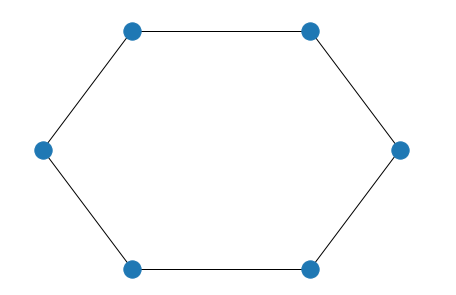
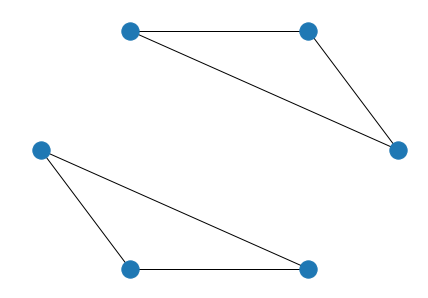 <br>

Another Example of Two Non-Isomorphic Graphs that fail the WL-Test <br>
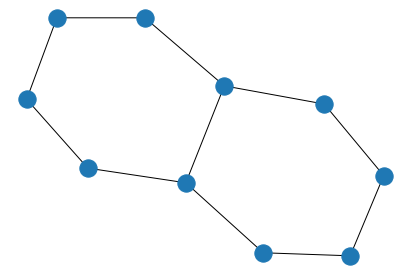
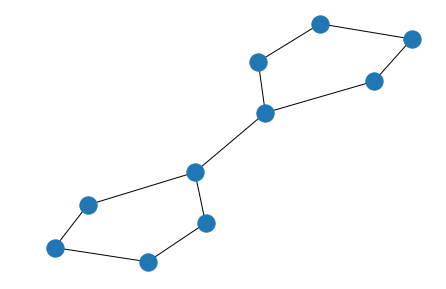

In [54]:
def evaluation(method, k):
    print(f'Method: {method}')
    
    # Generates two non-isomorphic graphs
    G = nx.Graph()
    G_edge_list = [(1, 2), (2, 3), (1, 3), (4, 5), (5, 6), (4, 6)]
    G.add_edges_from(G_edge_list)

    H = nx.Graph()
    H_edge_list = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)]
    H.add_edges_from(H_edge_list)
    
    G_ = nx.Graph()
    G_edge_list = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (3, 7), (7, 8), (8, 9), (9, 10), (10, 4)]
    G_.add_edges_from(G_edge_list)

    H_ = nx.Graph()
    H_edge_list = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (3, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 6)]
    H_.add_edges_from(H_edge_list)
    
    
    G1 = nx.davis_southern_women_graph()
    G2 = nx.karate_club_graph()
    G3 = nx.les_miserables_graph()
    G4 = nx.convert_node_labels_to_integers(G3)

    G5 = nx.convert_node_labels_to_integers(G3)
    G5.remove_edge(0, 1)

    print(f'Expected: False, got: {compare_graphs(G, H, method, k)}')
    print(f'Expected: False, got: {compare_graphs(G_, H_, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G1, G1, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G2, G2, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G3, G3, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G4, G4, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G5, G5, method, k)}')
    
    print(f'Expected: True, got: {compare_graphs(G3, G4, method, k)}')
    print(f'Expected: False, got: {compare_graphs(G3, G5, method, k)}')
    print(f'Expected: False, got: {compare_graphs(G4, G5, method, k)}')

In [8]:
evaluation('WL', k=3)

Expected: False, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: False, got: False
Expected: False, got: False


In [9]:
evaluation('kWL', k=3)

Expected: False, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: False, got: False
Expected: False, got: False


In [53]:
evaluation('fkWL', k=3)

NameError: name 'evaluation' is not defined